In [155]:
import numpy as np
from math import e
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
#NO sigmoid

In [156]:
class Calculate_xjLs:
    def get_wij_l(self,i,j,layer):
        return self.weights[layer-1][j-1][i]
    
    def get_w_l(self,layer):
        return self.weights[layer-1]
    
    def get_x_l(self,layer):
        return self.xjLs[layer]
    
    def get_xj_l(self,layer,j):
        if layer == self.num_layers and j==1:
            return self.xjLs[layer][0]
        return self.xjLs[layer][j]
    
    def get_xi_l(self,layer,i):
        return self.xjLs[layer][i]
    
    def get_dj_l(self, layer):
        return range(1,self.new_layers[layer]+1) #doesn't include threshold i=0
    
    def get_di_l(self, layer):
        return range(self.new_layers[layer]+1) #includes threshold i=0
    
    def calculate_xjLs(self,x):
        xjLs = [x]
        sjLs = []
        for layer in range(1,self.num_layers+1):
            x_l = [1] if layer != self.num_layers else [] #the final layer doesn't have a one
            s_l = []
            
            weights_for_layer = self.get_w_l(layer)
            for w_jl in weights_for_layer: #picking specific weights of one output (j)
                s_jl = np.matmul(x,w_jl.T)
                x_jl = self.activation_func(s_jl)
                x_l.append(x_jl)
                s_l.append(s_jl)
            
            xjLs.append(x_l)
            sjLs.append(s_l)
            x = x_l
        return xjLs, sjLs

class CalculateDeltas:
    def calculate_deltaL(self,x,y):
        x_1L = self.get_xj_l(self.num_layers,1)
        return [(x_1L-y)*self.derivative_of_activation_func(x_1L)]
    
    def calculate_deltas(self,layer,deltas_layer):
        #when layer is three gives deltas for two (already made deltaL), when layer is 2 it gives deltas for 1 --> stop at layer 2
        if layer == 1:
            return [deltas_layer]
        layer_m1 = layer-1
        d_layer = self.get_dj_l(layer)
        d_layer_m1 = range(1,self.new_layers[layer_m1]+1) #don't need a delta for the i=0 bc you are finding deltas for the row before layer_m1
        
        deltas_layer_m1_i = []
        
        for i in d_layer_m1:
            sum_of_j_paths = 0
            for j in d_layer:
                deltaj = deltas_layer[j-1]
                sum_of_j_paths += deltaj*self.get_wij_l(i,j,layer)
                #j-1 because the weights for j=1 are actually the first weights as j=0 is 1
            
            delta_layer_m1_i = self.derivative_of_activation_func(self.sjLs[layer_m1-1][i-1]) * sum_of_j_paths #-1 becuase no sjs for layer 1
            deltas_layer_m1_i.append(delta_layer_m1_i)
            
        return self.calculate_deltas(layer-1,deltas_layer_m1_i) + [deltas_layer]
    
     

In [157]:
class Plot:
    def simple_plot(self,X,preds):
        data = np.concatenate([np.array(X),np.array(preds).reshape(-1,1)],axis=1)
        df = pd.DataFrame(data, columns = ["x1","x2","y"])
        sns.scatterplot(data=df, x="x1", y="x2", hue="y")
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.show()
        
    def plot_ein(self):
        preds = self.calculate_preds(self.Xorig)
        if self.activation == "tahn": preds = np.sign(preds)
        self.simple_plot(self.Xorig, preds)
     
    def plot_eout(self):
        X = np.random.uniform(-1.0,1.0,(1000,2))
        preds = self.calculate_preds(X)
        if self.activation == "tahn": preds = np.sign(preds)
        y = self.find_actual_y(X)
        self.simple_plot(X, preds)
        self.simple_plot(X, y)
        preds = self.calculate_preds(X)
        plt.plot(preds,preds,"go")
        plt.plot(preds,y,"bo")
        plt.vlines(preds,preds,y, colors='k', linestyles='solid', label='')
        plt.show()

In [158]:
class Line():
    def create_line(self):
        if self.type == "linear regressor":
            self.mbs = np.random.uniform(10.0,0.0,self.input+1)
        if self.type == "PLA":
            self.mbs = np.random.uniform(1.0,0.0,self.input-1+1)
        if self.type == "circle":
            self.r = np.random.uniform(.8,0.0,1)
    def find_actual_y(self,X):
        if self.type == "PLA":
            return np.sign(np.matmul(self.add_thresholdCol(X)[:,:-1],self.mbs.T) - X[:,-1])
        if self.type == "linear regressor":
            return np.matmul(self.add_thresholdCol(X),self.mbs.T)
        if self.type == "circle":
            return [1 if x else -1 for x in np.sum(X**2,axis=1)>self.r**2]


    
    

In [159]:
class SGDGradient:
    
    def sgd_gradient(self):
        
        for layer in range(1,self.num_layers+1):
            layer_m1 = layer-1 #wij_2 where 2=layer is the weights between layer 1 (layer-1) and layer 2 (layer)
            delta_layer = self.deltas[layer-1] #delta layer 2 is the first delta at index 0
            dj_ls = self.get_dj_l(layer)
            di_ls = self.get_di_l(layer_m1)
            for j in dj_ls:
                deltaj_l = delta_layer[j-1]
                for i in di_ls:
                    wij_l = self.get_wij_l(i,j,layer)
                    xi_layer_m1 = self.get_xi_l(layer_m1,i)
                    gradient = -self.n*xi_layer_m1*deltaj_l
                    self.weights[layer-1][j-1][i] = wij_l + gradient
        
        
        
    def sgd_epoch(self):
        vals = list(range(self.N))
        random.shuffle(vals)
        for v in vals:
            x, y = self.X[v],self.y[v]
            self.xjLs,self.sjLs = self.calculate_xjLs(x)
            self.deltaL = self.calculate_deltaL(x,y)
            self.deltas = self.calculate_deltas(self.num_layers,self.deltaL)
            self.sgd_gradient()
        return self.weights 

In [160]:
class ActivationFunc:
    def activation_func(self,sj):
        if self.activation == "relu":
            return max(0,sj)
        if self.activation == "tahn":
            return (e**sj-e**-sj)/(e**sj+e**-sj)

    
    def derivative_of_activation_func(self,s):
        if self.activation == "relu":
            return 0 if s<0 else 1
        if self.activation == "tahn":
            return (1-(self.activation_func(s))**2)
       

In [171]:


class NeuralNetwork(Line,Plot,ActivationFunc,Calculate_xjLs,CalculateDeltas,SGDGradient):
    def __init__(self):
        self.N = 100
        self.input = 2
        self.new_layers = [2,3,3,9,1]
        self.n = .1
        self.num_layers = len(self.new_layers)-1
        self.type = "circle"
        self.activation = "tahn"
        self.init_weights()
        self.createData()
        
        
        self.ein = self.mse(self.X,self.y)
        print("Pre Adjusting Ein %s" % self.ein)
        self.runSGD()
        
        print("Final Weights %s" % self.weights)      
        print("Num Iterations %s" %self.num_iter)
        self.ein = self.mse(self.X,self.y)
        print("Ein %s" % self.ein)
        
        self.eout = self.eout()
        print("Eout %s" % self.eout)
        
        self.plot_ein()
        self.plot_eout()
        
    
      
        
####################################################
    def runSGD(self):
        self.num_iter = 0
        hump = 0
        for x in range(1000):
            wt = self.weights_list()
            self.num_iter += 1
            self.sgd_epoch()
            wt1 = self.weights_list()
            if np.sqrt(sum((wt-wt1)**2)) <.01: #np.linalg.norm
                hump += 1
                if hump>1000:
                    break
    def add_thresholdCol(self,X):
        return np.concatenate([[[1]for x in range(len(X))],X],axis=1)
    
    def createData(self):
        self.create_line()
        self.Xorig = np.random.uniform(-1.0,1.0,(self.N,self.input))
        self.y = self.find_actual_y(self.Xorig)
        self.X = self.add_thresholdCol(self.Xorig)

    def weights_list(self):
        change = []
        for layer in range(1,self.num_layers+1):
                layer_m1 = layer -1
                dj_ls = self.get_dj_l(layer)
                di_ls = self.get_dj_l(layer_m1)
                change += [self.get_wij_l(i,j,layer)for i in di_ls for j in dj_ls]
        return np.array(change) 
    
    def init_weights(self):
        self.weights = []
        for layer in range(self.num_layers):
            dj_ls = self.new_layers[layer+1]
            di_ls = self.new_layers[layer]+1
            self.weights.append(np.random.uniform(-1.0,1.0,(dj_ls,di_ls)))
        
    def mse(self,X,y):
        w = self.weights
        return sum([(self.calculate_xjLs(X[v])[0][-1][0] - y[v])**2 for v in range(len(X))])/len(X)
    
    def calculate_preds(self,X):
        X = self.add_thresholdCol(X)
        return [self.calculate_xjLs(x)[0][-1][0] for x in X]
        
    
    def eout(self):
        Xorig = np.random.uniform(-1.0,1.0,(100,2))
        X = self.add_thresholdCol(Xorig)
        y = self.find_actual_y(Xorig)
        return self.mse(X,y)

    

   

Pre Adjusting Ein 0.03974371450176265
Final Weights [array([[-1.17944612, -0.94466532,  3.13422393],
       [-0.08365994, -5.38252685, -2.46540607],
       [ 0.42945002,  0.37805199,  1.35824844]]), array([[ 0.4582652 ,  1.69196773, -3.50359617,  0.14605729],
       [-0.73202127,  0.11743009,  3.28895104, -1.1716187 ],
       [-0.01664985,  0.53024804, -1.32106448, -0.36850138]]), array([[-0.34740349, -0.06486285, -0.10500183, -1.08414368],
       [ 0.28827364,  0.90938694,  0.32609476, -0.35221207],
       [ 0.91881575,  0.41876718, -0.36522137, -1.29596137],
       [ 0.92112449,  1.12210885,  1.00767002,  0.29772037],
       [ 1.10981496,  1.87532423,  1.49364532, -0.37809567],
       [-0.460755  ,  0.20716571, -0.54552691, -0.79766847],
       [ 1.17354876,  0.68198194,  1.27078273,  1.00109887],
       [ 0.54914861,  0.12804589,  0.59155909,  0.71223268],
       [ 0.84160714,  0.40047325, -1.22080207,  0.97613941]]), array([[ 1.26942828, -0.54734002,  0.37468808,  0.54566388,  1.11

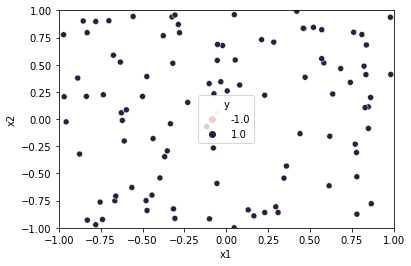

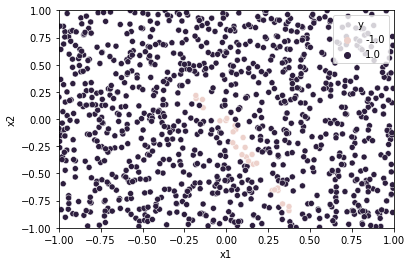

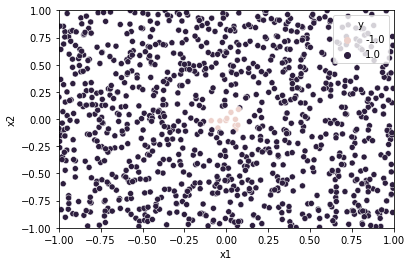

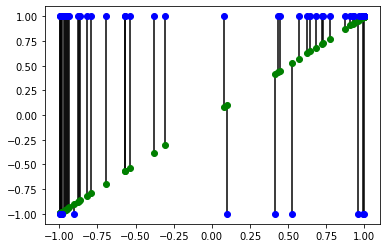

In [172]:
NeuralNetwork()

Pre Adjusting Ein 2.7501494873789114
Final Weights [array([[-1.88383983, -1.19426367,  5.76160304],
       [ 0.83848513, -4.87436732,  2.00615294],
       [-2.6707443 , -6.10227708, -4.78433465]]), array([[ 0.20242069,  3.72096253, -0.7206103 ,  0.08841725],
       [ 1.81377019, -0.78943436,  0.96289878, -0.43673482],
       [-2.06614795, -0.07011635,  3.24485271, -3.36285023]]), array([[ 0.89683148,  1.32243672,  0.51429392, -1.22681591],
       [ 0.59830843,  0.29170785,  0.74026632, -0.03281984],
       [-0.60637273, -0.88937634, -0.73902717,  0.7041248 ],
       [ 0.4959182 , -2.28814359,  0.2277498 , -0.93216324],
       [ 1.09219244,  2.11588771,  1.05471559, -1.99292572],
       [ 0.30847404,  0.89939597,  0.53521838,  2.41333958],
       [ 1.56462502,  0.05178255,  0.66669819,  0.16543204],
       [-0.44695192, -2.0059905 , -1.60241139,  1.87942675],
       [ 1.11891687,  2.31852339,  1.20986896, -2.16850644]]), array([[ 0.13868709,  0.30770692,  0.09025537, -0.26110008, -0.338

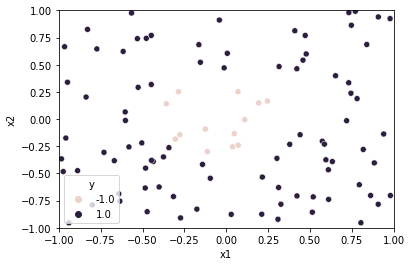

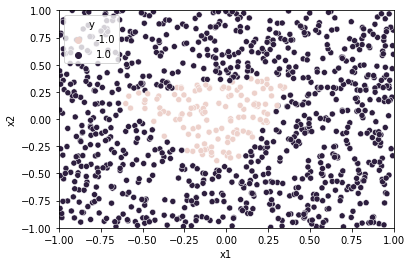

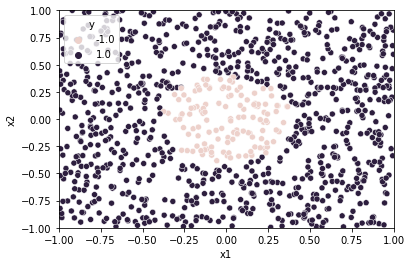

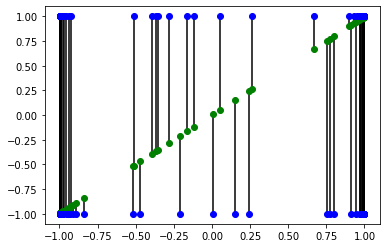

In [137]:
NeuralNetwork()

Pre Adjusting Ein 1.0616766229363517
Final Weights [array([[  6.0851364 , -10.20730458,   5.39626922],
       [  4.14476048,   3.52333452,   8.91128988],
       [ -7.51374704,  -1.15303661,  14.01310455]]), array([[ 5.35071069, -5.46189559, -5.37332265,  4.03529772],
       [-2.23937938,  0.66693124,  4.52293503, -5.19664441],
       [-5.87029556,  3.37941309,  1.73655208, -4.53829831]]), array([[-1.98602294, -1.66086254, -0.58449675,  2.37343502],
       [ 1.66221994,  0.98686616,  1.93123313, -0.12165069],
       [ 0.05790655, -2.30689104,  1.66106169,  1.7373534 ],
       [ 0.63897453,  2.67044587, -1.71061568, -1.09381362],
       [-0.30820183, -1.28999176,  2.05498108,  1.2915371 ],
       [ 1.79937492,  0.85753913, -0.1370241 , -2.11006066],
       [ 1.39383494,  0.34038165,  0.68078722,  0.18518626],
       [-0.11367276, -1.04423106,  0.87625123,  0.69673781],
       [ 1.88860274,  0.64447748, -0.99511622, -1.61298526]]), array([[ 0.50576694, -0.66932189, -0.30550808, -0.5581427

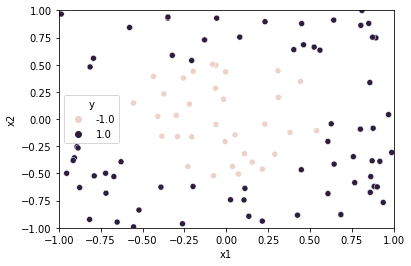

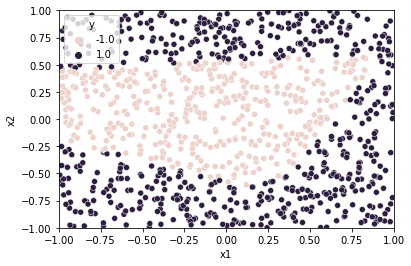

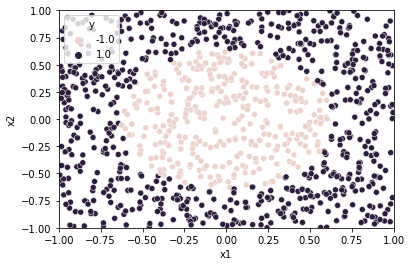

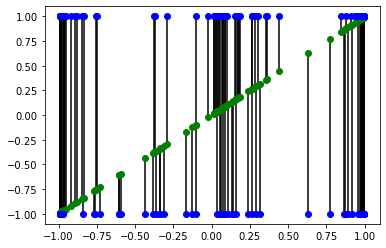

In [86]:
sum([[[1,2],[1,2]],[[1,2],[1,2]]],[])

[[1, 2], [1, 2], [1, 2], [1, 2]]

In [163]:
np.round([1.3,2])

array([1., 2.])

In [119]:
np.sum(np.array([[1,2],[1,3]]),axis=1)

array([3, 4])

In [72]:
X**2

array([[45.75163683, 56.05962688],
       [62.87518185, 70.9582767 ]])

In [173]:
1/(1-e**.04)

-24.50333324444784